<a href="https://colab.research.google.com/github/suma2011/Training_Lab/blob/main/GAN_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

GENERATIVE ADVERSARIAL NETWORK (GAN) DEMONSTRATION

📚 GAN CONCEPT:
A GAN consists of two neural networks competing against each other:
• Generator (G): Creates fake data from random noise
• Discriminator (D): Tries to distinguish real from fake data

Think of it like a counterfeiter (Generator) vs police (Discriminator)
The counterfeiter gets better at making fake money,
while the police get better at detecting fakes.
Eventually, the counterfeiter becomes so good that
the police can't tell the difference!

🔄 TRAINING PROCESS:
1. Generator creates fake data from random noise
2. Discriminator tries to classify real vs fake data
3. Both networks learn from their mistakes
4. Repeat until Generator fools Discriminator consistently

🎯 LOSS FUNCTIONS:
• Discriminator Loss: How well it distinguishes real from fake
• Generator Loss: How well it fools the discriminator
• Both networks try to minimize their respective losses

STARTING PRACTICAL DEMONSTRATION

1. Generating real 2D data...
Generat

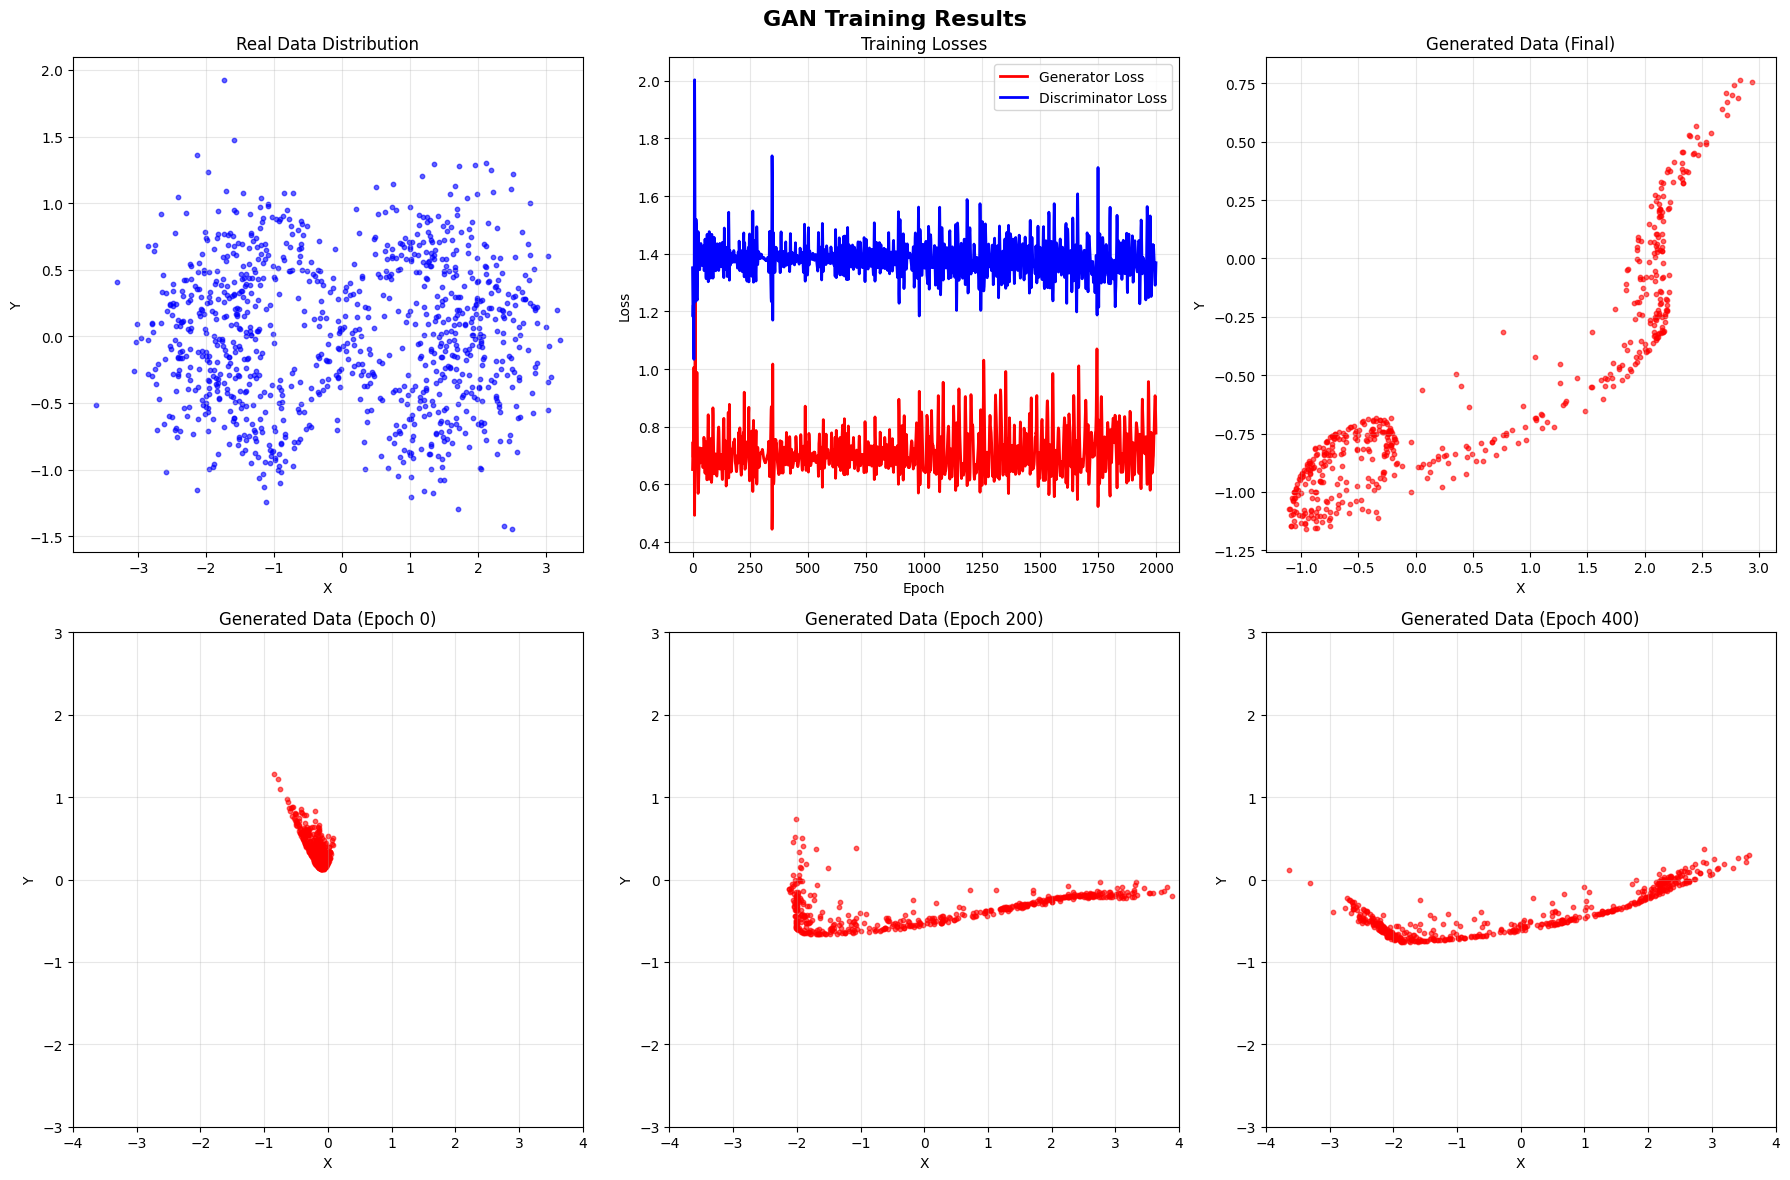


DEMONSTRATION COMPLETE!

🎉 What we achieved:
• Trained a Generator to create realistic 2D data
• Trained a Discriminator to detect fake data
• Observed the adversarial training process
• Visualized how generated data improves over time

💡 Key Observations:
• Generator loss should generally decrease over time
• Discriminator loss oscillates as it adapts to better fakes
• Generated data gradually resembles real data distribution
• Both networks reach an equilibrium (Nash equilibrium)

🚀 Next Steps:
• Try different architectures (DCGAN, StyleGAN, etc.)
• Apply to image generation (MNIST, CIFAR-10)
• Experiment with different loss functions
• Add regularization techniques (spectral normalization, etc.)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns
from matplotlib.animation import FuncAnimation
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

class Generator(nn.Module):
    """Generator network that creates fake data from noise"""
    def __init__(self, noise_dim=2, hidden_dim=128, output_dim=2):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(noise_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)

class Discriminator(nn.Module):
    """Discriminator network that distinguishes real from fake data"""
    def __init__(self, input_dim=2, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

def generate_real_data(n_samples=1000):
    """Generate real data - mixture of two Gaussians forming a figure-8 pattern"""
    # Create two clusters
    cluster1 = np.random.normal(loc=[-2, 0], scale=0.5, size=(n_samples//2, 2))
    cluster2 = np.random.normal(loc=[2, 0], scale=0.5, size=(n_samples//2, 2))

    # Add some circular pattern
    angles = np.linspace(0, 4*np.pi, n_samples//2)
    circle_x = 1.5 * np.cos(angles) + np.random.normal(0, 0.2, n_samples//2)
    circle_y = 0.8 * np.sin(2*angles) + np.random.normal(0, 0.2, n_samples//2)

    circle_data = np.column_stack([circle_x, circle_y])

    # Combine datasets
    real_data = np.vstack([cluster1[:n_samples//4], cluster2[:n_samples//4], circle_data])
    return torch.FloatTensor(real_data)

def train_gan(generator, discriminator, real_data, epochs=5000, batch_size=128, lr=0.0002):
    """Train the GAN"""
    # Loss function
    criterion = nn.BCELoss()

    # Optimizers
    g_optimizer = optim.Adam(generator.parameters(), lr=lr)
    d_optimizer = optim.Adam(discriminator.parameters(), lr=lr)

    # Data loader
    dataset = TensorDataset(real_data)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Training history
    g_losses = []
    d_losses = []
    generated_samples = []

    noise_dim = 2

    print("Starting GAN Training...")
    print("-" * 50)

    for epoch in range(epochs):
        epoch_g_loss = 0
        epoch_d_loss = 0

        for i, (real_batch,) in enumerate(dataloader):
            batch_size = real_batch.size(0)

            # Labels
            real_labels = torch.ones(batch_size, 1)
            fake_labels = torch.zeros(batch_size, 1)

            # Train Discriminator
            d_optimizer.zero_grad()

            # Real data
            d_real = discriminator(real_batch)
            d_real_loss = criterion(d_real, real_labels)

            # Fake data
            noise = torch.randn(batch_size, noise_dim)
            fake_batch = generator(noise)
            d_fake = discriminator(fake_batch.detach())
            d_fake_loss = criterion(d_fake, fake_labels)

            # Total discriminator loss
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            # Train Generator
            g_optimizer.zero_grad()

            # Generate fake data
            noise = torch.randn(batch_size, noise_dim)
            fake_batch = generator(noise)
            d_fake = discriminator(fake_batch)

            # Generator loss (try to fool discriminator)
            g_loss = criterion(d_fake, real_labels)
            g_loss.backward()
            g_optimizer.step()

            epoch_g_loss += g_loss.item()
            epoch_d_loss += d_loss.item()

        # Record losses
        g_losses.append(epoch_g_loss / len(dataloader))
        d_losses.append(epoch_d_loss / len(dataloader))

        # Save generated samples for visualization
        if epoch % 200 == 0:
            with torch.no_grad():
                noise = torch.randn(500, noise_dim)
                fake_samples = generator(noise)
                generated_samples.append((epoch, fake_samples.numpy()))

            print(f"Epoch {epoch:4d}/{epochs} | G Loss: {g_losses[-1]:.4f} | D Loss: {d_losses[-1]:.4f}")

    return g_losses, d_losses, generated_samples

def visualize_results(real_data, generated_samples, g_losses, d_losses):
    """Visualize the training results"""

    # Create subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('GAN Training Results', fontsize=16, fontweight='bold')

    # Plot 1: Real data
    axes[0, 0].scatter(real_data[:, 0], real_data[:, 1], alpha=0.6, c='blue', s=10)
    axes[0, 0].set_title('Real Data Distribution')
    axes[0, 0].set_xlabel('X')
    axes[0, 0].set_ylabel('Y')
    axes[0, 0].grid(True, alpha=0.3)

    # Plot 2: Training losses
    axes[0, 1].plot(g_losses, label='Generator Loss', color='red', linewidth=2)
    axes[0, 1].plot(d_losses, label='Discriminator Loss', color='blue', linewidth=2)
    axes[0, 1].set_title('Training Losses')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Plot 3: Final generated data
    if generated_samples:
        final_samples = generated_samples[-1][1]
        axes[0, 2].scatter(final_samples[:, 0], final_samples[:, 1], alpha=0.6, c='red', s=10)
        axes[0, 2].set_title('Generated Data (Final)')
        axes[0, 2].set_xlabel('X')
        axes[0, 2].set_ylabel('Y')
        axes[0, 2].grid(True, alpha=0.3)

    # Plot 4: Evolution of generated data
    if len(generated_samples) >= 3:
        for i, (epoch, samples) in enumerate(generated_samples[:3]):
            row = 1
            col = i
            axes[row, col].scatter(samples[:, 0], samples[:, 1], alpha=0.6, c='red', s=10)
            axes[row, col].set_title(f'Generated Data (Epoch {epoch})')
            axes[row, col].set_xlabel('X')
            axes[row, col].set_ylabel('Y')
            axes[row, col].grid(True, alpha=0.3)

            # Set consistent axis limits
            axes[row, col].set_xlim(-4, 4)
            axes[row, col].set_ylim(-3, 3)

    plt.tight_layout()
    plt.show()

def demonstrate_gan_concept():
    """Demonstrate the core GAN concept with explanations"""
    print("=" * 60)
    print("GENERATIVE ADVERSARIAL NETWORK (GAN) DEMONSTRATION")
    print("=" * 60)

    print("\n📚 GAN CONCEPT:")
    print("A GAN consists of two neural networks competing against each other:")
    print("• Generator (G): Creates fake data from random noise")
    print("• Discriminator (D): Tries to distinguish real from fake data")
    print("\nThink of it like a counterfeiter (Generator) vs police (Discriminator)")
    print("The counterfeiter gets better at making fake money,")
    print("while the police get better at detecting fakes.")
    print("Eventually, the counterfeiter becomes so good that")
    print("the police can't tell the difference!")

    print("\n🔄 TRAINING PROCESS:")
    print("1. Generator creates fake data from random noise")
    print("2. Discriminator tries to classify real vs fake data")
    print("3. Both networks learn from their mistakes")
    print("4. Repeat until Generator fools Discriminator consistently")

    print("\n🎯 LOSS FUNCTIONS:")
    print("• Discriminator Loss: How well it distinguishes real from fake")
    print("• Generator Loss: How well it fools the discriminator")
    print("• Both networks try to minimize their respective losses")

def main():
    """Main demonstration function"""
    demonstrate_gan_concept()

    print("\n" + "="*60)
    print("STARTING PRACTICAL DEMONSTRATION")
    print("="*60)

    # Generate real data
    print("\n1. Generating real 2D data...")
    real_data = generate_real_data(1000)
    print(f"Generated {len(real_data)} real data points")

    # Initialize networks
    print("\n2. Initializing networks...")
    generator = Generator(noise_dim=2, hidden_dim=128, output_dim=2)
    discriminator = Discriminator(input_dim=2, hidden_dim=128)

    print(f"Generator parameters: {sum(p.numel() for p in generator.parameters()):,}")
    print(f"Discriminator parameters: {sum(p.numel() for p in discriminator.parameters()):,}")

    # Train the GAN
    print("\n3. Training GAN...")
    g_losses, d_losses, generated_samples = train_gan(
        generator, discriminator, real_data,
        epochs=2000, batch_size=64, lr=0.0002
    )

    # Visualize results
    print("\n4. Visualizing results...")
    visualize_results(real_data.numpy(), generated_samples, g_losses, d_losses)

    print("\n" + "="*60)
    print("DEMONSTRATION COMPLETE!")
    print("="*60)

    print("\n🎉 What we achieved:")
    print("• Trained a Generator to create realistic 2D data")
    print("• Trained a Discriminator to detect fake data")
    print("• Observed the adversarial training process")
    print("• Visualized how generated data improves over time")

    print("\n💡 Key Observations:")
    print("• Generator loss should generally decrease over time")
    print("• Discriminator loss oscillates as it adapts to better fakes")
    print("• Generated data gradually resembles real data distribution")
    print("• Both networks reach an equilibrium (Nash equilibrium)")

    print("\n🚀 Next Steps:")
    print("• Try different architectures (DCGAN, StyleGAN, etc.)")
    print("• Apply to image generation (MNIST, CIFAR-10)")
    print("• Experiment with different loss functions")
    print("• Add regularization techniques (spectral normalization, etc.)")

if __name__ == "__main__":
    main()